In [72]:
import matplotlib.pyplot as plt
import numpy as np

import numpy as np
import matplotlib.pyplot as plt
import sys
import glob
import tqdm

sys.path.append("/Users/gliu/Downloads/02_Research/01_Projects/01_AMV/00_Commons/03_Scripts/")
sys.path.append("/Users/gliu/Downloads/02_Research/01_Projects/01_AMV/02_stochmod/03_Scripts/stochmod/model/")
from amv import proc,viz
import scm

In [73]:
def convert_Wm2(invar,h,dt,cp0=3996,rho=1026,verbose=True):
    """
    outvar = convert_Wm2(invar,h,dt,cp0=3996,rho=1026,verbose=True)
    
    Converts an input array [LON x LAT x TIME] from W/m2 to 1/time
    by multiplying by dt/(rho*cp0*h).
    If input is not 3D, appends dimensions to the front and assumes
    last dimension is time.
    
    Parameters
    ----------
    invar : ARRAY [LON x LAT x TIME]
        Variable to convert, in W/m2 or W/m2/degC
    h     : ARRAY [LON X LAT x TIME (or MONTH)]
        Mixed layer depth to use. Can be seasonal or monthly
    dt    : Numeric
        Integration Timestep in seconds
    cp0   : Numeric, optional
        Specific Heat [J/(kg*C)]. The default is 3996.
    rho   : TYPE, optional
        Density of Seawater [kg/m3]. The default is 1026.
    verbose : BOOL, optional
        Set to True to print messages.The default is True

    Returns
    -------
    outvar : ARRAY [LON x LAT x TIME]
        Converted variable
    """
    
    # Append dimensions to front, so variables are 3-D
    while len(invar.shape) < 3:
        if verbose:
            print("Warning! invar is not 3D. Appending dims to front.")
        invar = invar[None,:] 
    while len(h.shape) < 3: 
        if verbose:
            print("Warning! h is not 3D. Appending dims to front.")
        h = h[None,:] 
    
    # Check last dimensions of h
    if invar.shape[-1] != h.shape[-1]:
        print("Found seasonal data for h. Tiling to match time for invar")
        ntile = int(invar.shape[-1]/h.shape[-1])
        h     = np.tile(h,ntile)
    
    # Perform Conversion
    outvar = invar * dt / (rho*cp0*h)
    
    return outvar.squeeze()

def load_inputs(mconfig,frcname,input_path):
    """
    lon,lat,mld,kprevall,damping,alpha = load_inputs(mconfig,frcname,input_path)
    
    Load stochastic model inputs from [input_path] directory. This includes
    atmospheric damping, mixed layer depth, entrainment month, and stochastic
    forcing amplitudes. 

    Parameters
    ----------
    mconfig : STR
        Model Configuration. Currently supports [SLAB_PIC,FULL_PIC,FULL_HTR]
    frcname : STR
        Name of forcing. Supports ["allrandom","uniform"] or loads "[frcname].npy"
    input_path : STR
        Where all the data is stored
    
    Returns
    -------
    lon : ARRAY [lon,]
        Longitudes
    lat : ARRAY [lat,]
        Latitudes
    h   : ARRAY [lon180 x lat x mon (or time)]
        Mixed Layer depth cycle
    kprevall : ARRAY [lon180 x lat x mon (or time)]
        Indices for detrainment months
    damping  : ARRAY [lon180 x lat x mon (or time)]
        Atmospheric damping
    alpha    : ARRAY [lon180 x lat x pc x mon (or time)]
        Stochastic forcing amplitudes
    
    Adapted from scm.load_data
    """
    # Load lat/lon
    lon           = np.load(input_path+"CESM1_lon180.npy")
    lat           = np.load(input_path+"CESM1_lat.npy")
    nlon,nlat     = len(lon),len(lat)
    
    # Load Data (MLD and kprev) [lon180 x lat x mon]
    if mconfig == "FULL_HTR": # Load ensemble mean historical MLDs
        h       = np.load(input_path+"%s_HMXL_hclim.npy" % mconfig) # Climatological MLD
        kprevall  = np.load(input_path+"%s_HMXL_kprev.npy" % mconfig) # Entraining Month
    else:
        h       = np.load(input_path+"FULL_PIC_HMXL_hclim.npy") # Climatological MLD
        kprevall  = np.load(input_path+"FULL_PIC_HMXL_kprev.npy") # Entraining Month
    
    # Load Atmospheric Damping [lon180 x lat x mon]
    if mconfig == "SLAB_PIC":
        damping   = np.load(input_path+mconfig+"_NHFLX_Damping_monwin3_sig005_dof894_mode4.npy")
    elif mconfig == "FULL_PIC":
        damping   = np.load(input_path+mconfig+"_NHFLX_Damping_monwin3_sig005_dof1893_mode4.npy")
    elif mconfig =="FULL_HTR":
        damping   = np.load(input_path+mconfig+"_NHFLX_Damping_monwin3_sig020_dof082_mode4.npy")
    else:
        print("Currently supported damping mconfig are [SLAB_PIC,FULL_PIC,FULL_HTR]")
    
    # Load Alpha (Forcing Amplitudes) [lon180 x lat x pc x mon], easier for tiling
    if frcname == "allrandom":
        alpha     = np.random.normal(0,1,(nlon,nlat,1,12)) # [lon x lat x 1 x 12]
    elif frcname == "uniform":
        alpha     = np.ones((nlon,nlat,1,12))
    else: # [lon x lat x mon x pc]
        alpha     = np.load(input_path+frcname+".npy")
    
    return lon,lat,h,kprevall,damping,alpha


def cut_regions(inputs,lon,lat,bboxsim,pointmode,points=[-30,50],awgt=1):
    """
    outputs,[lonr],[latr] = cut_regions(inputs,lon,lat,bboxsim,pointmode,points=[-30,50],awgt=1)
    
    Cut input variables ([lon x lat x otherdims]) to region specified by bboxsim
    [lonw, lonE, latS, latN] or individual point, determined by pointmode.
    Automatically handles dimensions > 3 by reshaping.

    Parameters
    ----------
    inputs : ARRAY of ARRAYs [lon180 x lat x otherdims]
        Arrays containing variables to cut/crop
    lon : ARRAY [lon,]
        Longitudes
    lat : ARRAY [lat,]
        Latitudes
    bboxsim : ARRAY [lonW,lonE,latS,latN]
        Bounding box of target region
    pointmode : INT [0, 1, or 2]
        0 = Cut to region [bboxsim]
        1 = Select points = [lonf,latf]
        2 = Area-weighted average over [bboxsim]
    points : [ARRAY[lonf,latf], optional
        Coordinates of point to restrict to . The default is [-30,50].
    awgt : INT (0,1,2), optional
        Area weighting (see the area_avg function). The default is 1.

    Returns
    -------
    outputs : ARRAY of ARRAYs [lon180 x lat x otherdims]
        Cropped variables
    if pointmode == 0, also returns lonr, latr for the region
        
    """
    
    # Looping for each variable
    outputs = []
    
    for v in range(len(inputs)):
        invar = inputs[v]
        
        # Temporarily combine dims >= 3
        reshapeflag = False
        if len(invar.shape) > 3: 
            print("Combining dims...")
            reshapeflag = True
            shapevar = invar.shape
            nlon     = shapevar[0]
            nlat     = shapevar[1]
            nother   = np.prod(shapevar[2:])
            invar    = invar.reshape(nlon,nlat,nother)
        
        # Restrict to region/point
        if pointmode == 0: # Restrict to region
            varr,lonr,latr = proc.sel_region(invar,lon,lat,bboxsim)
        elif pointmode == 1: # Restrict to point
            lonf,latf = points
            klon,klat = proc.find_latlon(lonf,latf,lon,lat)
            varr = invar[klon,klat,:]
        elif pointmode == 2: # Area weighted average (cos-weighting)
            varr = proc.area_avg(invar,bboxsim,lon,lat,awgt)
        else:
            print("Invalid pointmode (accepts 0,1, or 2)")
        
        # Reshape back to original
        if reshapeflag:
            if pointmode == 0:
                newshape = np.hstack([[len(lonr),len(latr)],shapevar[2:]])
            else:
                newshape = shapevar[2:]
                #newshape = np.hstack([[1,1],shapevar[2:]])
                #varr = varr[None,None,...] # Add lat/lon singleton dims
            print("Reshaping to size %s" % (str(newshape)))
            varr = varr.reshape(newshape)
        if pointmode != 0:
            varr = varr[None,None,...]
        
        
        # Append to output
        outputs.append(varr)
    if pointmode == 0:
        return outputs,lonr,latr
    else:
        return outputs

In [74]:
# Directories
input_path = "/Users/gliu/Downloads/02_Research/01_Projects/01_AMV/02_stochmod/01_Data/model_input/"
output_path = "/Users/gliu/Downloads/02_Research/01_Projects/01_AMV/02_stochmod/01_Data/model_output/"
# Model Params
ampq       = True # Set to true to multiply stochastic forcing by a set value
mconfig    = "SLAB_PIC"
frcname    = "flxeof_090pct_SLAB-PIC_eofcorr2" 
limaskname = "limask180_FULL-HTR.npy" 

# Additional Constants
t_end      = 12000 # Sim Length
dt         = 3600*24*30 # Timestep
T0         = 0 # Init Temp

pointmode  = 0 
points     = [-30,50]
bboxsim    = [-100,20,-20,90] # Simulation Box

In [75]:
# Load data in
# ------------
lon,lat,h,kprevall,damping,alpha = load_inputs(mconfig,frcname,input_path)
hblt = np.load(input_path + "SLAB_PIC_hblt.npy") # Slab fixed MLD
hblt = np.ones(hblt.shape) * hblt.mean(2)[:,:,None]

In [76]:
# Apply landice mask to all inputs
# --------------------------------
limask    = np.load(input_path+limaskname)
h        *= limask[:,:,None]
kprevall *= limask[:,:,None]
damping  *= limask[:,:,None]
alpha    *= limask[:,:,None,None]
hblt     *= limask[:,:,None]

In [20]:
# Restrict to region or point
# ---------------------------
inputs = [h,kprevall,damping,alpha,hblt]
if pointmode == 0:
    outputs,lonr,latr = cut_regions(inputs,lon,lat,bboxsim,pointmode,points=points)
else:
    outputs = cut_regions(inputs,lon,lat,bboxsim,pointmode,points=points)
h,kprev,damping,alpha,hblt = outputs

Combining dims...
Reshaping to size [ 97 117  69  12]


In [22]:
# Convert lambda 

h_in = hblt.copy() # Used fixed slab model MLD

# Convert to w/m2
# ---------------
lbd_a   = convert_Wm2(damping,h_in,dt)
#F       = convert_Wm2(forcing,h_in,dt) # [lon x lat x time]

In [26]:
# Get annually averaged lambda
lbd      = lbd_a.mean(2)

(<matplotlib.collections.QuadMesh at 0x7fb571aab1d0>,
 <matplotlib.colorbar.Colorbar at 0x7fb5406e6410>)

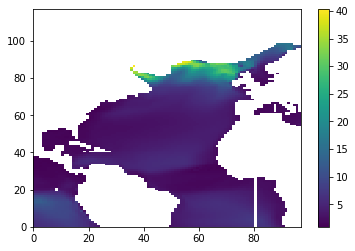

In [29]:
plt.pcolormesh(1/(lbd.T)),plt.colorbar()

In [31]:
# Now calculate q-corr

def oldmethod(lbd):
    a = 1-lbd
    mult = 2*a**2 / (1+a)
    return mult

def method1(lbd,include_b=True):
    a = 1-lbd
    b = (1-np.exp(-lbd))/lbd
    
    if include_b:
        mult = ((1-b)**2 + (1-b**2)*a + 2*b*a**2)/(1+a)
    else:
        mult = (1+a+b**2*(1-a)-2*(1-a**2))/(1+a)
    return mult

def method2(lbd,include_b=True,original=True):
    a = 1-lbd
    b = (1-np.exp(-lbd))/lbd
    
    
    
    # Calculate variance of Q
    if original:
        mid_term  = (b**2 * (1-a)) / (2 * (1+a)**2)
    else:
        mid_term  = (b**2 * (1-a)) / (2)
    
    if include_b:
        last_term = b*(1-a)
    else:
        last_term = (1-a)
    
    mult = 1 + mid_term - last_term
    return mult

In [68]:
oldcorr = oldmethod(lbd)
corr1   = method1(lbd)
corr2   = method2(lbd)
#corr2   = method2(lbd,original=False)

corr = [oldcorr,corr1,corr2]
corrn = [r"$\frac{2a^2}{1+a}$","Method 1","Method 2"]

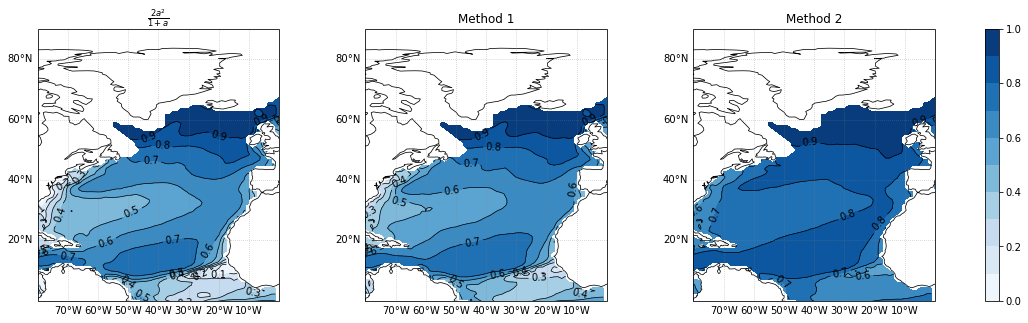

In [71]:
import cartopy.crs as ccrs
import cmocean

bboxplot =[-80,0,0,90] 

clvls = np.arange(0,1.1,0.1)
fig,axs = plt.subplots(1,3,subplot_kw={'projection':ccrs.PlateCarree()},figsize=(18,5))


for i in range(3):
    
    ax = axs[i]
    ax = viz.add_coast_grid(ax=ax,bbox=bboxplot)
    pcm = ax.contourf(lonr,latr,corr[i].T,levels=clvls,cmap="Blues")
    cl = ax.contour(lonr,latr,corr[i].T,levels=clvls,colors="k",linewidths=0.7)
    ax.clabel(cl)
    ax.set_title(corrn[i])

fig.colorbar(pcm,ax=axs.ravel().tolist(),fraction=0.025)

In [54]:
bboxsim

[-100, 20, -20, 90]

In [ ]:
# Lets 